BGE（BAAI General Embedding）是一套“先预训练、再对比学习、再指令化多任务微调”的双塔 / bi-encoder 文本向量模型。

- 预训练（Pre-train）：用 RetroMAE 的检索导向 MAE 方法，在大规模无标注语料（中文使用悟道 / WuDao）上做“编码 → 解码复原文本”的自监督训练；这一步产出的是“只会复原、不适合直接算相似度”的 encoder； ￼ 
- 通用对比学习（General-purpose contrastive fine-tuning）：在大规模无标注成对数据上（C-MTP unlabeled，中文约 1 亿对，英文约 2 亿对）做 InfoNCE，只用 in-batch 负样本，把 batch 做很大（论文给到最多约 19,200），显著提升判别力；
$$\mathcal{L}=-\log \frac{e^{\langle e_p,e_q\rangle/\tau}}{e^{\langle e_p,e_q\rangle/\tau}+\sum_{q’\in \mathcal{Q}’} e^{\langle e_p,e_{q’}\rangle/\tau}}$$

- 任务特化微调（Task-specific fine-tuning）：在高质量标注数据（C-MTP labeled）上继续对比学习，并做两件事：
    - 指令化输入：在查询（query）一侧拼接任务指令（如 “为这个句子生成表示以用于检索相关文章：”/“Represent this sentence for searching relevant passages:”），用来统一多任务表示；
    - 加入硬负样本：除 in-batch 负样本外，每个正样本再挖一个硬负（用 ANN 检索从任务语料挖近邻）；

BGE-M3 一次前向就能产出 3 类向量：dense、sparse（lexical）、multi-vector（ColBERT 风格）。做法是“共享一个编码器 + 三条读出/打分路径 + 统一训练（自知识蒸馏）”。

- Dense：取 [CLS] 的隐藏状态做池化并 L2 归一化，直接点积/余弦做相关性 $s_{dense}$。 ￼
- Sparse（lexical）：对每个 token 的隐藏状态过一层线性 + ReLU 得到该词的权重 $w_{t}$，查询和文档的重合词按权重相乘求和得到 $s_{lex}$。输出是稀疏词权重（字典/倒排友好）。 ￼ ￼
- Multi-vector（ColBERT）：把所有 token 隐藏状态经投影矩阵 $W_{mul}$ 得到一串向量 $E_q,E_p$，用 late-interaction 按“对每个查询 token 在文档里找最相似的 token，再求平均”的方式得到 $s_{mul}$。 ￼

论文用自知识蒸馏（Self-KD）：三种打分 $s_{dense},s_{lex},s_{mul}$ 先加权集成成一个教师分数，再用 InfoNCE 让每条读出路径都去拟合这个“软标签”，避免多目标训练互相掣肘；同时配合大批次与难负样本。整体是 RetroMAE 预训练 → 无监督对比学习 → 统一微调（带 Self-KD）的多阶段流程。 ￼

epoch 01 | loss 3.5262 | recall@1 0.380
epoch 02 | loss 0.4636 | recall@1 0.981
epoch 03 | loss 0.1570 | recall@1 0.999
epoch 04 | loss 0.0930 | recall@1 1.000
epoch 05 | loss 0.0753 | recall@1 1.000
epoch 06 | loss 0.0659 | recall@1 1.000
epoch 07 | loss 0.0596 | recall@1 1.000
epoch 08 | loss 0.0536 | recall@1 1.000
epoch 09 | loss 0.0494 | recall@1 1.000
epoch 10 | loss 0.0452 | recall@1 1.000
epoch 11 | loss 0.0433 | recall@1 1.000
epoch 12 | loss 0.0413 | recall@1 1.000
epoch 13 | loss 0.0385 | recall@1 1.000
epoch 14 | loss 0.0364 | recall@1 1.000
epoch 15 | loss 0.0347 | recall@1 1.000
epoch 16 | loss 0.0331 | recall@1 1.000
epoch 17 | loss 0.0315 | recall@1 1.000
epoch 18 | loss 0.0304 | recall@1 1.000
epoch 19 | loss 0.0293 | recall@1 1.000
epoch 20 | loss 0.0280 | recall@1 1.000


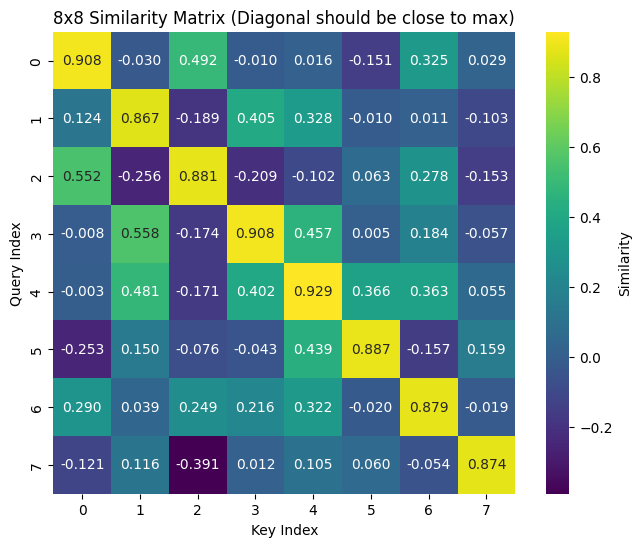

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

N = 4000
D_in = 32
W_true = torch.randn(D_in, D_in)
X = torch.randn(N, D_in)
Y = X @ W_true + 0.05 * torch.randn_like(X)

def make_mlp(d_in=32, d_hid=128, d_out=64):
    return nn.Sequential(
        nn.Linear(d_in, d_hid), nn.ReLU(),
        nn.Linear(d_hid, d_out)
    )

q_encoder = make_mlp(D_in, 128, 64)
k_encoder = make_mlp(D_in, 128, 64)

opt = torch.optim.Adam(list(q_encoder.parameters()) + list(k_encoder.parameters()), lr=1e-3)

def info_nce(q, k, temperature=0.07):
    """
    q: [B, d]  from query tower
    k: [B, d]  from key tower (one-to-one with q)
    use other samples in the same batch as negative samples
    """
    q = F.normalize(q, dim=-1)
    k = F.normalize(k, dim=-1)

    logits = q @ k.t() / temperature          # [B, B] similarity/τ 
    labels = torch.arange(q.size(0))          # correct matches on the diagonal
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.t(), labels)
    loss = (loss_i2t + loss_t2i) * 0.5
    return loss, logits

batch_size = 256
epochs = 20
temperature = 0.07

for ep in range(1, epochs + 1):
    perm = torch.randperm(N)
    X_shuf, Y_shuf = X[perm], Y[perm]

    total_loss, total_acc = 0.0, 0.0
    steps = 0

    for i in range(0, N, batch_size):
        xb = X_shuf[i:i+batch_size]
        yb = Y_shuf[i:i+batch_size]
        if xb.size(0) < 2:  # at least one negative sample
            continue

        q = q_encoder(xb)    # [B, d]
        k = k_encoder(yb)    # [B, d]

        loss, logits = info_nce(q, k, temperature)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            labels = torch.arange(logits.size(0))
            acc_q2k = (logits.argmax(dim=1) == labels).float().mean()
            acc_k2q = (logits.t().argmax(dim=1) == labels).float().mean()
            acc = 0.5 * (acc_q2k + acc_k2q)

        total_loss += loss.item()
        total_acc += acc.item()
        steps += 1

    print(f"epoch {ep:02d} | loss {total_loss/steps:.4f} | recall@1 {total_acc/steps:.3f}")

with torch.no_grad():
    q_vecs = F.normalize(q_encoder(X[:8]), dim=-1)  # query
    k_vecs = F.normalize(k_encoder(Y[:8]), dim=-1)  # key
    sims = q_vecs @ k_vecs.t()                      # [8, 8]
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(sims.cpu().numpy(), annot=True, fmt='.3f', cmap='viridis', 
                square=True, cbar_kws={'label': 'Similarity'})
    plt.title('8x8 Similarity Matrix (Diagonal should be close to max)')
    plt.xlabel('Key Index')
    plt.ylabel('Query Index')
    plt.show()